In [1]:
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt

from skimage.color import rgb2gray
from skimage import exposure
from skimage.morphology import ball, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from scipy import signal

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## .1. Define the paths

In [3]:
### Obs: 'ep_data' was the alias I used for the folder name.
PATH_EP_ROOT = "/content/drive/MyDrive/ep_data"
PATH_DATASET_GRAY = os.path.join(PATH_EP_ROOT, "dataset_gray")

In [4]:
# Creates dataset folder if it does not exist
PATH_DATASET_AUG = os.path.join(PATH_EP_ROOT, "dataset_augmented")
if not os.path.exists(PATH_DATASET_AUG):
    os.mkdir(PATH_DATASET_AUG)
else:
    print(f"'{PATH_DATASET_AUG}' already exists!")

'/content/drive/MyDrive/ep_data/dataset_augmented' already exists!


## .2. Utils

In [10]:
def rescale_to_uint8(img):
  #img_min = np.min(img)
  #scale = np.max(img) - img_min
  #return img_as_ubyte(255*((img - img_min)/scale))
  #return np.uint8(255*((img - img_min)/scale))
  return img_as_ubyte(img)

def intensity_log(image_array):
    # rescale_to_uint8(exposure.adjust_log(img/255)) ?
    return exposure.adjust_log(image_array, 1)

def intensity_exp(image_array):
    image_32 = image_array.astype(np.float32)
    image_32 = image_32 / 255

    image_32 = np.exp(image_32)
    image_32 = image_32 - 1
    image_32 = image_32 / (np.exp(1) - 0.99)
    
    return rescale_to_uint8(image_32)

def intensity_mean_conv(image_array):
    # rescale_to_uint8(rank.mean(img, kernel)) ?
    kernel = np.ones((3, 3))
    kernel /= 9
    img_mean = signal.convolve2d(image_array, kernel, mode='valid')
    img_mean = img_mean.astype(np.uint8)
    return img_mean

def intensity_gradient(image_array):
    bg_gradient = np.uint8(np.floor(np.linspace(0, 255, 256*256).reshape(256, 256).T))
    return rescale_to_uint8((image_array/255 + bg_gradient/255)/2)

In [6]:
def plot(img):
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img, cmap="gray")
    plt.show()

---
---
### Tests before running transformations for all images on the dataset

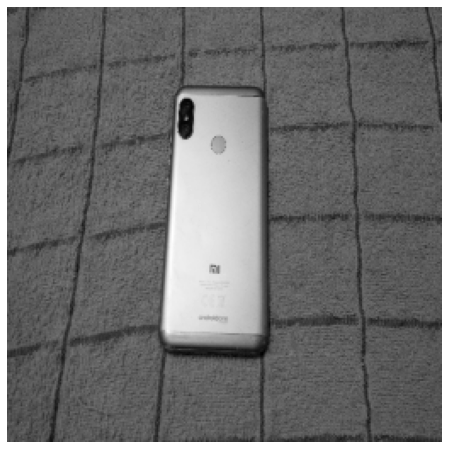

In [7]:
img = imageio.imread(os.path.join(PATH_DATASET_GRAY, "celular", "celular_obj2_p1_ni_f2.png"))
plot(img)

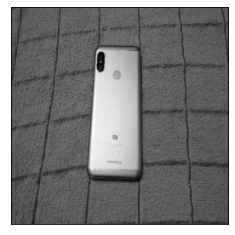

In [23]:
fig = plt.imshow(img, cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

### Log example

In [17]:
intensity_exp(img)

array([[55, 57, 55, ..., 76, 65, 71],
       [41, 49, 51, ..., 69, 58, 78],
       [47, 50, 52, ..., 67, 69, 67],
       ...,
       [72, 69, 73, ..., 59, 56, 60],
       [75, 66, 76, ..., 57, 54, 54],
       [68, 58, 77, ..., 51, 39, 54]], dtype=uint8)

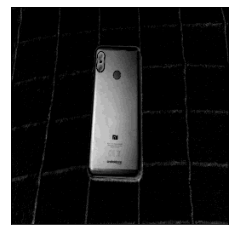

In [15]:
fig = plt.imshow(img - intensity_log(img), cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

### Exp example

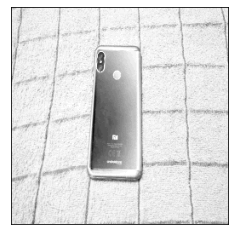

In [16]:
fig = plt.imshow(img - intensity_exp(img), cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

### Convolution example

In [20]:
intensity_mean_conv(img)

array([[ 75,  77,  79, ..., 100,  95,  97],
       [ 74,  75,  76, ...,  99,  96,  97],
       [ 81,  85,  84, ..., 102, 102, 102],
       ...,
       [ 97,  97,  96, ...,  90,  90,  93],
       [100,  99,  98, ...,  85,  83,  87],
       [ 99,  99,  97, ...,  77,  74,  79]], dtype=uint8)

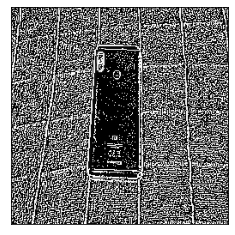

In [19]:
fig = plt.imshow(img[1:255, 1:255] - intensity_mean_conv(img), cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

### Sum with background gradient

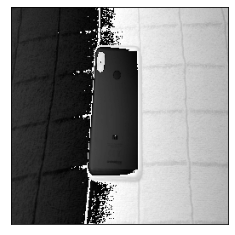

In [21]:
fig = plt.imshow(img - intensity_gradient(img), cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

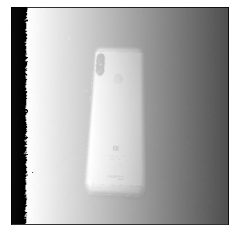

In [ ]:
fig = plt.imshow( img - rescale_to_uint8((img/255 + bg_gradient/255)/2), cmap = "gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show(fig)

## .3. Augmentation process

In [ ]:
def intensity_log(image_array):
    # rescale_to_uint8(exposure.adjust_log(img/255)) ?
    return exposure.adjust_log(image_array, 1)

def intensity_exp(image_array):
    image_32 = image_array.astype(np.float32)
    image_32 = image_32 / 255

    image_32 = np.exp(image_32)
    image_32 = image_32 - 1
    image_32 = image_32 / (np.exp(1) - 0.99)
    
    return rescale_to_uint8(image_32)

def intensity_mean_conv(image_array):
    # rescale_to_uint8(rank.mean(img, kernel)) ?
    kernel = np.ones((3, 3))
    kernel /= 9
    img_mean = signal.convolve2d(image_array, kernel, mode='valid')
    img_mean = img_mean.astype(np.uint8)
    return img_mean

def intensity_gradient(image_array):
    bg_gradient = np.uint8(np.floor(np.linspace(0, 255, 256*256).reshape(256, 256).T))
    return rescale_to_uint8((image_array/255 + bg_gradient/255)/2)

Generate augmented dataset:

In [ ]:
for dirpath, dirname, filename in os.walk(PATH_DATASET_GRAY):
    if dirpath != PATH_DATASET_GRAY:
        # 0. Define class
        object_class = dirpath.split("/")[-1]
        folder_path = os.path.join(PATH_DATASET_AUG, object_class)

        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        else:
            print(f"'{folder_path}' already exists!")

        # 1. Generate augmentations
        print(f"\nCurrent object class: {object_class}")
        for file in tqdm(filename, desc=f"{object_class}  -> "):
            if file.split(".")[-1] in ["jpg", "png", "jpeg"]:
                img = imageio.imread(os.path.join(dirpath, file))
                file_no_ext = file.split(".")[0]

                # imagem original
                imageio.imwrite(os.path.join(folder_path, file_no_ext + "_identity.png"), img)

                # log image
                imageio.imwrite(os.path.join(folder_path, file_no_ext + "_log.png"),
                                intensity_log(img))

                # exp image
                imageio.imwrite(os.path.join(folder_path, file_no_ext + "_exp.png"),
                                intensity_exp(img))

                # convolution image
                imageio.imwrite(os.path.join(folder_path, file_no_ext + "_convolution.png"),
                                intensity_mean_conv(img))

                # sum with background with gradient
                imageio.imwrite(os.path.join(folder_path, file_no_ext + "_gradient.png"),
                                intensity_gradient(img))

'/content/drive/MyDrive/ep_data/dataset_augmented/celular' already exists!

Current object class: celular


celular  -> : 100%|██████████| 171/171 [07:42<00:00,  2.71s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/sapato' already exists!

Current object class: sapato


sapato  -> : 100%|██████████| 216/216 [09:28<00:00,  2.63s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/chinelo' already exists!

Current object class: chinelo


chinelo  -> : 100%|██████████| 144/144 [06:31<00:00,  2.72s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/caneca' already exists!

Current object class: caneca


caneca  -> : 100%|██████████| 144/144 [04:47<00:00,  2.00s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/tesoura' already exists!

Current object class: tesoura


tesoura  -> : 100%|██████████| 144/144 [00:38<00:00,  3.70it/s]


'/content/drive/MyDrive/ep_data/dataset_augmented/chave' already exists!

Current object class: chave


chave  -> : 0it [00:00, ?it/s]


'/content/drive/MyDrive/ep_data/dataset_augmented/livro' already exists!

Current object class: livro


livro  -> : 100%|██████████| 144/144 [08:51<00:00,  3.69s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/portacopo' already exists!

Current object class: portacopo


portacopo  -> : 100%|██████████| 144/144 [08:37<00:00,  3.60s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/garrafa' already exists!

Current object class: garrafa


garrafa  -> : 100%|██████████| 144/144 [08:42<00:00,  3.63s/it]


'/content/drive/MyDrive/ep_data/dataset_augmented/prato' already exists!

Current object class: prato


prato  -> : 100%|██████████| 72/72 [05:09<00:00,  4.29s/it]
